In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns



In [2]:
# Load dataset
file_path_df = "https://raw.githubusercontent.com/diogo-costa-silva/assets/main/data/google_play_store/googleplaystore.csv"
file_path_df_reviews = "https://raw.githubusercontent.com/diogo-costa-silva/assets/main/data/google_play_store/googleplaystore_user_reviews.csv"

df = pd.read_csv(file_path_df)
df_reviews = pd.read_csv(file_path_df_reviews)

In [3]:




# Step 1: Convert 'Reviews' to numeric
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# Step 2: Convert 'Size' to MegaBytes (MB)
def convert_size(size):
    if 'M' in size:
        return float(size.replace('M', ''))
    elif 'k' in size:
        return float(size.replace('k', '')) / 1024  # 1 MB = 1024 kB
    elif 'G' in size:
        return float(size.replace('G', '')) * 1024  # 1 GB = 1024 MB
    else:
        return np.nan  # for 'Varies with device' and other non-numeric values

df['Size'] = df['Size'].map(convert_size)

# Step 3: Clean 'Installs' Column
df['Installs'] = df['Installs'].str.replace(',', '').str.replace('+', '')
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Step 4: Convert 'Price' to float
df['Price'] = df['Price'].str.replace('$', '')
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Step 5: Convert 'Last Updated' to datetime
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

# Step 6: Correct '0' value in 'Type' column
df.loc[df['Type'] == '0', 'Type'] = 'Free'

# Step 7: Drop the row with multiple NaN values (where 'Type' was '0')
index_to_drop = df.index[df['Type'] == 'Free'][0]
df.drop(index_to_drop, inplace=True)

# Step 8: Clean 'Genres' column
df['Genres'] = df['Genres'].str.replace('Music & Audio', 'Music')
df['Genres'] = df['Genres'].apply(lambda x: np.nan if 'February 11, 2018' in x else x)
df['Genres'] = df['Genres'].str.split(';')

# Step 9: Create new columns from 'Current Ver' and 'Android Ver'
df['Is_Varied_Version'] = df['Current Ver'].apply(lambda x: 1 if str(x).lower() == 'varies with device' else 0)

def categorize_android_ver(version):
    if pd.isnull(version):
        return np.nan
    if ' and up' in version:
        min_ver = version.split(' and up')[0]
    elif ' - ' in version:
        min_ver = version.split(' - ')[0]
    else:
        return 'Other'
    
    if min_ver < '4.0':
        return 'Below 4.0'
    elif '4.0' <= min_ver < '5.0':
        return '4.0 - 4.9'
    elif '5.0' <= min_ver < '6.0':
        return '5.0 - 5.9'
    elif '6.0' <= min_ver < '7.0':
        return '6.0 - 6.9'
    elif '7.0' <= min_ver < '8.0':
        return '7.0 - 7.9'
    elif '8.0' <= min_ver < '9.0':
        return '8.0 - 8.9'
    else:
        return '9.0 and above'

df['Min_Android_Ver_Category'] = df['Android Ver'].apply(categorize_android_ver)


/var/folders/6x/sp_vy0g12kv_vw9114lrmss40000gn/T/ipykernel_37545/2326822214.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Installs'] = df['Installs'].str.replace(',', '').str.replace('+', '')
/var/folders/6x/sp_vy0g12kv_vw9114lrmss40000gn/T/ipykernel_37545/2326822214.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Price'] = df['Price'].str.replace('$', '')


## EDA

- Summary Statistics: Provide summary statistics to understand the central tendency, spread, and shape of the distribution of the dataset.
- Handling Missing Values: Explore columns with missing values and decide whether to fill them or drop them based on the context.
- Visualization: Use various plots to visualize the data and understand the patterns, relationships, anomalies, etc.
Outliers Detection: Detect outliers in the relevant columns, which can significantly impact the results of the analysis.
- Feature Engineering: Create new features that might help in better understanding the patterns in the data.

In [4]:
# Summary statistics for numerical columns
numerical_summary = df.describe(include=[np.number]).T

# Summary statistics for categorical columns
categorical_summary = df.describe(include=[np.object]).T

numerical_summary, categorical_summary


/var/folders/6x/sp_vy0g12kv_vw9114lrmss40000gn/T/ipykernel_37545/3358641636.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_summary = df.describe(include=[np.object]).T


(                     count          mean           std       min     25%  \
 Rating              9366.0  4.193348e+00  5.374591e-01  1.000000     4.0   
 Reviews            10839.0  4.441939e+05  2.927893e+06  0.000000    38.0   
 Size                9144.0  2.151644e+01  2.259030e+01  0.008301     4.9   
 Installs           10839.0  1.546576e+07  8.503315e+07  0.000000  1000.0   
 Price              10839.0  1.027463e+00  1.595044e+01  0.000000     0.0   
 Is_Varied_Version  10840.0  1.345941e-01  3.413052e-01  0.000000     0.0   
 
                         50%        75%           max  
 Rating                  4.3        4.5  1.900000e+01  
 Reviews              2094.0    54783.0  7.815831e+07  
 Size                   13.0       30.0  1.000000e+02  
 Installs           100000.0  5000000.0  1.000000e+09  
 Price                   0.0        0.0  4.000000e+02  
 Is_Varied_Version       0.0        0.0  1.000000e+00  ,
                           count unique                 top   freq

In [5]:
# Identifying columns with missing values and the count of missing values in each column
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values


Size                        1696
Rating                      1474
Current Ver                    8
Android Ver                    3
Min_Android_Ver_Category       3
Reviews                        1
Installs                       1
Type                           1
Price                          1
Content Rating                 1
Genres                         1
Last Updated                   1
dtype: int64

In [6]:
# Imputing missing values in 'Size' and 'Rating' columns with their respective median values
df['Size'].fillna(df['Size'].median(), inplace=True)
df['Rating'].fillna(df['Rating'].median(), inplace=True)

# Confirming if the missing values are filled in 'Size' and 'Rating' columns
missing_size_and_rating = df[['Size', 'Rating']].isnull().sum()
missing_size_and_rating


Size      0
Rating    0
dtype: int64

In [7]:
# Imputing missing values in 'Current Ver', 'Android Ver', and 'Min_Android_Ver_Category' with the most frequent value
for column in ['Current Ver', 'Android Ver', 'Min_Android_Ver_Category']:
    most_frequent_value = df[column].mode()[0]
    df[column].fillna(most_frequent_value, inplace=True)

# Dropping rows with missing values in 'Reviews', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', and 'Last Updated'
df.dropna(subset=['Reviews', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated'], inplace=True)

# Confirming if all the missing values are handled
missing_values_after_handling = df.isnull().sum()
missing_values_after_handling = missing_values_after_handling[missing_values_after_handling > 0]
missing_values_after_handling


Series([], dtype: int64)

## Data Visualizations

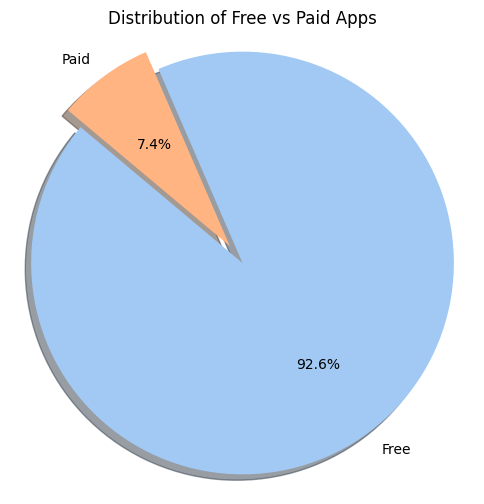

In [11]:
# Set up the matplotlib figure
plt.figure(figsize=(6, 6))

# Data to plot
labels = df['Type'].value_counts().index
sizes = df['Type'].value_counts().values
colors = sns.color_palette('pastel')[0:2]  # Using pastel color palette from seaborn for the pie chart
explode = (0.1, 0)  # explode 1st slice for better visibility

# Plotting the Pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Free vs Paid Apps')
plt.show()


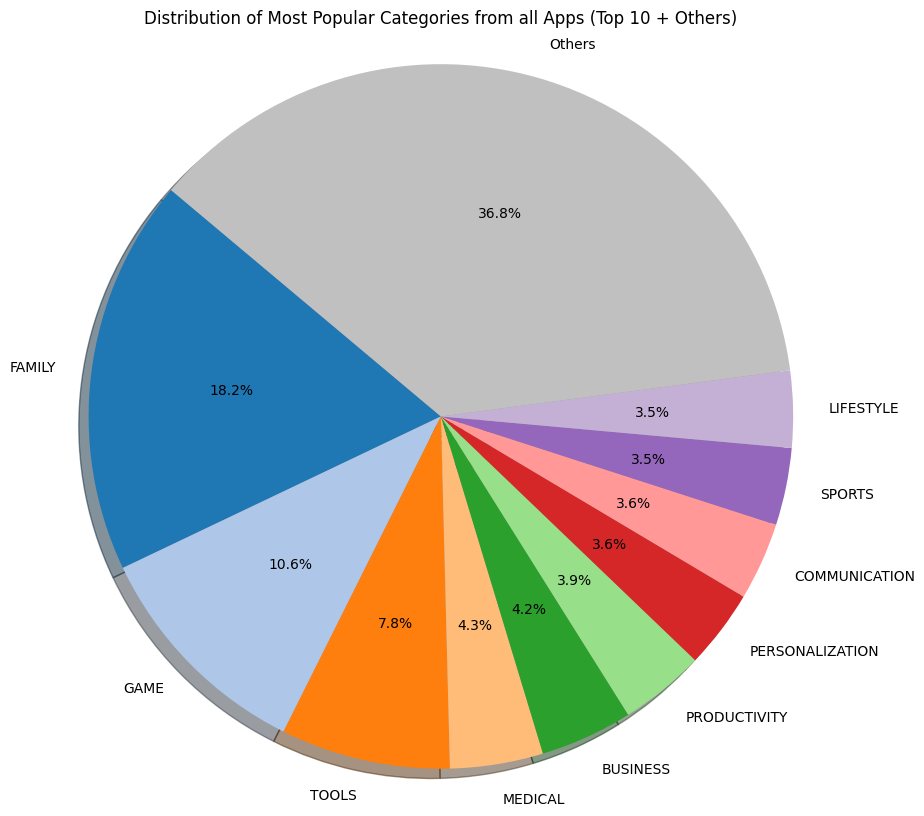

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(10, 10))

# Data Preparation: Selecting top 10 categories and grouping the rest as 'Others'
top_n = 10
category_counts = df['Category'].value_counts()
top_categories = category_counts.head(top_n)
top_categories['Others'] = category_counts.iloc[top_n:].sum()

# Selecting a color palette with sufficient unique colors and ensuring 'Others' is gray
labels = top_categories.index
colors = sns.color_palette('tab20', len(labels) - 1)  # tab20 palette has 20 unique colors
colors.append('silver')  # Adding a distinct silver color for 'Others'

# Plotting the final adjusted Pie chart with correct distinct colors
plt.pie(top_categories, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Most Popular Categories from all Apps (Top 10 + Others)')

# Display the plot
plt.show()
